In [353]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [354]:
def replacer_ctype(text):
  if text=='GENERAL' or text=='general' or text=='Gen':
    return 'GEN'
  elif text=='sc':
    return 'SC'
  elif text=='st':
    return 'ST'
  else:
    return text

def replacer_sex(text):
  if text=='MALE' or text=='male':
    return 'M'
  elif text=='FEMALE' or text=='female':
    return 'F'
  else:
    return text

In [355]:
#Preliminary Data Cleaning

df_root= pd.read_csv("All_States_GE.csv")
df= df_root[df_root['Year']==2019]
df2 = df.drop(['Assembly_No', 'Constituency_No', 'Year', 'month', 'Poll_No', 'DelimID',
               'Valid_Votes', 'Electors', 'Sub_Region', 'N_Cand', 'Turnout_Percentage',
               'Margin', 'ENOP', 'pid', 'Party_ID', 'last_poll', 'Contested', 'Last_Party',
               'Last_Party_ID', 'Last_Constituency_Name', 'Same_Constituency', 'Same_Party',
               'No_Terms', 'TCPD_Prof_Main_Desc', 'TCPD_Prof_Second', 'TCPD_Prof_Second_Desc',
               'Election_Type', 'Deposit_Lost', 'Votes'], axis=1)
nota_df = df2[(df2['Candidate'] == 'NOTA') | (df2['Candidate'] == 'None of the Above')]
df3 = df2[(df2['Candidate'] != 'NOTA') & (df2['Candidate'] != 'None of the Above')]
df3['Candidate_Type'].fillna('GEN', inplace=True)
df4= df3.copy(deep=True)
df4['ctype']= df3['Candidate_Type'].apply(lambda x: replacer_ctype(str(x)))
df4['sex']= df3['Sex'].apply(lambda x: replacer_sex(str(x)))
df5= df4.drop(['Sex', 'Candidate_Type'], axis=1)
df6= df5[df5['sex']!='nan']

<ipython-input-355-a8501f4a2b36>:3: DtypeWarning: Columns (17,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_root= pd.read_csv("All_States_GE.csv")
<ipython-input-355-a8501f4a2b36>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Candidate_Type'].fillna('GEN', inplace=True)


**INSIGHT 1**  
There are very few constituencies (6) which are classified as General where candidates belonging SC/ST communities emerge victorious. Of these constituencies, 2 are in Arunachal Pradesh which is already 68.79% ST according to the 2011 census. There is no caste based data for the other 4 constituencies as a whole.   

This implies that SC and ST candidates have difficulty in winning constituencies which are dominated by non-reserved communities.

This inference is strengthened by the fact that among all the non-winning SC/ST candidates contesting in General seats, 89.50% of such candidates secured less 2% voteshare in their constituencies.

number of SC/ST candidates winning in general constituencies= 6



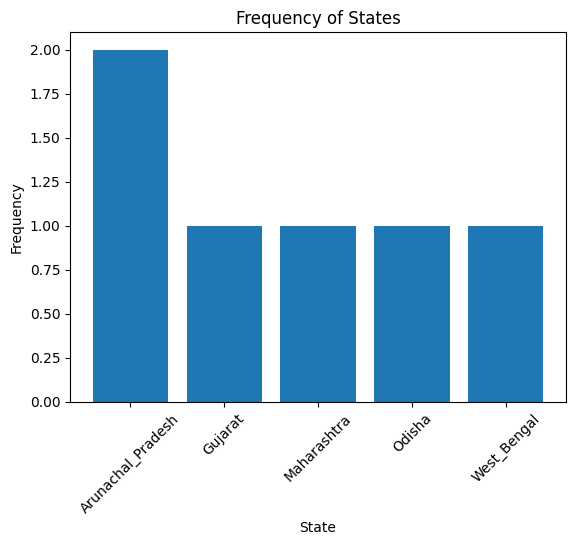

SC/ST candidates securing less than 2% votes in general constituencies= 89.50617283950618



<ipython-input-356-7bcb2d5a3feb>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5_info2= df5_info1[((df5_info1['Constituency_Type']=='GEN') & (df5['Position']!=1))]


In [356]:
# INSIGHT 1

df6_info1 = df6[df6['ctype'] != df6['Constituency_Type']]
arr= df6_info1[((df6_info1['Position']==1) & (df6_info1['Constituency_Type']=='GEN'))]
ls= arr['Margin_Percentage'].tolist()
ls.sort()
print("number of SC/ST candidates winning in general constituencies= "+str(len(ls))+"\n")

party_counts = arr['State_Name'].value_counts()
plt.bar(party_counts.index, party_counts.values)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Frequency of States')
plt.xticks(rotation=45)
plt.show()

df5_info1 = df5[df5['ctype'] != df5['Constituency_Type']]
df5_info2= df5_info1[((df5_info1['Constituency_Type']=='GEN') & (df5['Position']!=1))]
arr2= df5_info2['Vote_Share_Percentage'].tolist()
arr2.sort()

count=0
for item in arr2:
  if item<=2:
    count+=1

vote_val= count*100/len(arr2)
print("SC/ST candidates securing less than 2% votes in general constituencies= "+str(vote_val)+"\n")

**Model for Classification: SVM**

I am using a aSupport Vector Machine for predicting whether a certain set of parameters ensures that a particular candidate will win or not.

These are some of the additional data cleaning steps followed:
1. Classifying the states on the basis of regions (https://en.wikipedia.org/wiki/Zonal_Councils_of_India) to ensure that dimensions do not become very high
2. Rather than predicting the position, I am predicting win or loss
3. One Hot Encoding for states and parties and Ordinal encoding for the other featues
4. Classifying parties on the basis of the number of candidates they have fielded. This is also done to reduce the dimensionality


In [357]:
def party_classify(party, freq, num):
  if freq[party]<=num:
    return 'other'
  else:
    return party

def party_formatter(text):
  arr= text.split()
  if len(arr)==1:
      return text.lower()
  else:
    string= ""
    for word in arr:
      string+= word[0]
    return string.lower()

def outcomes(num):
  if num==1:
    return 1
  else:
    return 0

def find_state_region(state):
    # Define the lists
    regions = {
        'North': ['Chandigarh', 'Delhi', 'Haryana', 'Himachal_Pradesh', 'Jammu_&_Kashmir', 'Punjab', 'Rajasthan'],
        'South': ['Andaman_&_Nicobar_Islands', 'Andhra_Pradesh', 'Karnataka', 'Kerala', 'Puducherry', 'Tamil_Nadu', 'Telangana', 'Lakshadweep'],
        'Central': ['Chhattisgarh', 'Madhya_Pradesh', 'Uttar_Pradesh', 'Uttarakhand'],
        'East': ['Bihar', 'Jharkhand', 'Odisha', 'West_Bengal'],
        'West': ['Dadra_&_Nagar_Haveli', 'Daman_&_Diu', 'Goa', 'Gujarat', 'Maharashtra'],
        'Northeast': ['Arunachal_Pradesh', 'Sikkim', 'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Assam', 'Meghalaya']
    }

    # Check the state in each region
    for region, states in regions.items():
        if state in states:
            return region
    return None

In [358]:
#Data Cleaning

df_root= pd.read_csv("All_States_GE.csv")
df= df_root[((df_root['Year']==2019) | (df_root['Year']==2014) |(df_root['Year']==2009) |(df_root['Year']==2004))]
df2 = df.drop(['Assembly_No', 'Constituency_No', 'Year', 'month', 'Poll_No', 'DelimID',
               'Valid_Votes', 'Electors', 'Sub_Region', 'N_Cand', 'Turnout_Percentage',
               'Margin', 'ENOP', 'pid', 'Party_ID', 'last_poll', 'Contested', 'Last_Party',
               'Last_Party_ID', 'Last_Constituency_Name', 'Same_Constituency', 'Same_Party',
               'No_Terms', 'TCPD_Prof_Main_Desc', 'TCPD_Prof_Second', 'TCPD_Prof_Second_Desc',
               'Election_Type', 'Deposit_Lost', 'Votes'], axis=1)
nota_df = df2[(df2['Candidate'] == 'NOTA') | (df2['Candidate'] == 'None of the Above')]
df3 = df2[(df2['Candidate'] != 'NOTA') & (df2['Candidate'] != 'None of the Above')]
df3['Candidate_Type'].fillna('GEN', inplace=True)
df4= df3.copy(deep=True)
df4['ctype']= df3['Candidate_Type'].apply(lambda x: replacer_ctype(str(x)))
df4['sex']= df3['Sex'].apply(lambda x: replacer_sex(str(x)))
df5= df4.drop(['Sex', 'Candidate_Type'], axis=1)
df6= df5[df5['sex']!='nan']

<ipython-input-358-df5b8f63a304>:3: DtypeWarning: Columns (17,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_root= pd.read_csv("All_States_GE.csv")
<ipython-input-358-df5b8f63a304>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Candidate_Type'].fillna('GEN', inplace=True)


In [359]:
ml_df= df6.drop(['Candidate', 'Constituency_Name', 'Vote_Share_Percentage', 'Margin_Percentage',
       'Party_Type_TCPD', 'MyNeta_education', 'TCPD_Prof_Main'], axis=1)

ml_df2= ml_df.copy(deep=True)
ml_df2['party']=ml_df['Party'].apply(lambda x: party_formatter(str(x)))
ml_df2['outcome']=ml_df['Position'].apply(lambda x: outcomes(x))
ml_df2['region']=ml_df['State_Name'].apply(lambda x: find_state_region(x))

ml_df3= ml_df2.drop(['Party', 'Position', 'State_Name'], axis=1)

arr3 = ml_df3['party'].tolist()

party_count = {}

for party in arr3:
    if party not in party_count:
        party_count[party] = 1
    else:
        party_count[party] += 1

ml_df3['party_name']= ml_df3['party'].apply(lambda x: party_classify(str(x), party_count, 10))
ml_df4= ml_df3.drop(['party'], axis=1)

In [360]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ml_df5 = ml_df4.copy(deep=True)
ordinal_encode_columns = ['Constituency_Type', 'ctype', 'sex', 'region']
label_encoder = LabelEncoder()
for col in ordinal_encode_columns:
    ml_df5[col] = label_encoder.fit_transform(ml_df5[col])
ml_df5 = pd.get_dummies(ml_df5, columns=['party_name'])

In [ ]:
X = ml_df5.drop('outcome', axis=1)
y = ml_df5['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [362]:
ml_df5

,Constituency_Type,Turncoat,Incumbent,Recontest,ctype,sex,outcome,region,party_name_aaap,party_name_aapp,...,party_name_trs,party_name_ukkd,party_name_umk,party_name_upjp,party_name_vba,party_name_vck,party_name_vip,party_name_vpi,party_name_wpoi,party_name_ysrcp
0,0,False,False,True,0,1,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,False,False,False,0,1,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,False,False,False,0,1,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,False,False,True,0,1,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,False,False,False,0,1,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31574,1,False,False,True,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31582,0,False,False,False,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31587,0,False,False,True,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31593,0,False,False,False,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This is the code used for optimising the hyperparameters:

```
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC

svm_model = SVC()
param_grid = {
    'C': [0.1, 1, 10],    
    'kernel': ['linear', 'rbf', 'poly'],
}
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score))
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)```
